 <table style="background-color:#FFFFFF">

   <tr>

   <td><img src="https://upload.wikimedia.org/wikipedia/commons/9/95/Logo_EPFL_2019.svg" width="150x"/>

   </td>

   <td>

   <h1> <b>CS-461: Foundation Models and Generative AI</b> </h1>

   Prof. Charlotte Bunne

   </td>

   </tr>

 </table>

 # 📚 Graded Assignment 1

 ### CS-461: Foundation Models and Generative AI - Fall 2025  - Due: October 8, 23:59 CET



 Welcome to the first graded assignment!

 In this assignment, you will **implement and explore self-supervised learning** on a downsampled subset of the [ImageNet-1k dataset](https://www.image-net.org/), and evaluate how well your model generalizes **both in-distribution and out-of-distribution (OOD)**.



 ---



 ## 🎯 Learning Objectives

 By completing this assignment, you will learn to:

 - Implement a custom **encoder** and **projection head** for images

 - Experiment with **data augmentations** for self-supervised learning

 - Train a model using a **self-supervised loss**

 - Evaluate learned representations with **k-NN** and **linear probes**

 - Assess **out-of-distribution (OOD) generalization** to unseen classes

 - Save, visualize, and submit results in a reproducible way



 ---



 ## ⚡ Practical Notes

 - **Dataset:**

   - Training: 200 ImageNet classes, 500 images each (100k total)

   - Validation: 200 ImageNet classes, 50 images each (10k total)

   - **OOD dataset:** 200 unseen classes, 50 images each (10k total)

 - Use OOD only for **evaluation**, never for training.

 - Checkpoints and evaluation intervals are already set up — your main tasks are to fill in missing functions and customize the model.

 - Some helper utilities (e.g., dataset loaders, probes) are provided in `utils.py`.



 ---



 👉 **Deliverables:** You will submit:

 - Your modified **`models.py`**

 - Trained weights in **`final_model.safetensors`**

 - A short **report.md** (max 500 words) — including **discussion of OOD results**

 - This completed notebook **CS461_Assignment1.ipynb**



 ---



 ⚠️ **Important:** Don’t forget to fill in your **SCIPER number** and **full name** in Section 0, otherwise you will receive **0 points**.

 First, we import packages and set up the device. \

 Feel free to add any additional packages you may need.

In [ ]:
# Automatically reloads modules when you make changes (useful during development)
# %load_ext autoreload
# %autoreload 2


In [2]:
from pathlib import Path
import shutil
import json
import math
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import time
import os
import importlib.util

import torch, gc
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Subset
from safetensors.torch import save_model
from safetensors.torch import load_model
from torchvision.datasets import CIFAR10
from IPython.display import Image, display
import matplotlib.image as mpimg

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import json

 # 🆔 0. SCIPER Number and Name



 ⚠️ **IMPORTANT!** ⚠️

 You **must** fill in your **SCIPER number** and **full name** below.



 This is **required for automatic grading**.

 If you do **not** provide this information, you will receive **0️⃣ (zero)** for this assignment.

In [ ]:
SCIPER = 404588  # Replace with your SCIPER number
LAST_NAME = "El Houjjaji"  # Replace with your last name
FIRST_NAME = "Chaimae"  # Replace with your first name

 ## 1. Datasets & Utilities

 - In the following, we will work with a subset of the ImageNet-1k dataset: color images downsampled to 64×64, covering 200 classes.

 - The training set contains 500 images per class (100,000 images in total), and the validation set contains 50 images per class (10,000 images in total).

 - The Out-Of-Distribution (OOD) datasets contain images from classes not present in the training set. It contains 50 images from 200 different classes (1,000 images in total).

 - The purpose of these OOD datasets is to evaluate the generalization capabilities of the learned representations. You should not use it for training.

 - During evalution, we will measure your model's performance on another OOD dataset (different from the one provided here), so make sure to not overfit on the provided OOD dataset.



 <!-- Let's download/load it and define a default transformation turning a PIL Image into a `torch.tensor` -->

 Make sure that you have access to the `/shared/CS461/cs461_assignment1_data/` folder. The folder structure should look like this:

 ```

 cs461_assignment1_data/

 └── train.npz

 └── val.npz

 └── ood.npz

 ```



 Import dataset class and other utilities you developed in previous homeworks:

In [ ]:
print("############################### START ##############################")
start =  time.time()


In [ ]:
from utils import SimCLRTransform, simclr_collate_fn
from utils import ImageDatasetNPZ, default_transform, seed_all
from utils import run_knn_probe, run_linear_probe, extract_features_and_labels, visualize_predictions, visualize_tsne, visualize_tsne_highlight_labels

 For reproducibility, you can use the provided `seed_all` function to set the random seed for all relevant libraries (Python, NumPy, PyTorch).

In [ ]:
seed_all(42)  # For reproducibility, you can use any integer here

 You probably want to implement custom data augmentations for the self-supervised learning method you choose. \

 Feel free to swap the `default_transform` defined below and create multiple instances of datasets with different transforms.

In [ ]:
data_dir = Path('/shared/CS461/cs461_assignment1_data/')

In [ ]:
simclr_transform_train = SimCLRTransform(size=64)
simclr_transform_test = SimCLRTransform(size=64)

train_dataset = ImageDatasetNPZ(data_dir / 'train.npz', transform=simclr_transform_train)
val_dataset = ImageDatasetNPZ(data_dir / 'val.npz', transform=simclr_transform_test)
train_plain = ImageDatasetNPZ(data_dir / 'train.npz', transform=default_transform)
val_plain = ImageDatasetNPZ(data_dir / 'val.npz', transform=default_transform)

 You can split the provided OOD dataset into a training and validation set using the code below. \

 You should not use the training split for actually training your models, but only for evaluation (e.g. kNN or linear probing).

In [ ]:
rng = np.random.RandomState(42)
ds_ood = ImageDatasetNPZ(data_dir / 'ood.npz', transform=default_transform)
ood_val_ratio = 0.2
train_mask = rng.permutation(len(ds_ood)) >= int(len(ds_ood) * ood_val_ratio)
ds_oods_train = torch.utils.data.Subset(ds_ood, np.where(train_mask)[0])
ds_oods_val = torch.utils.data.Subset(ds_ood, np.where(~train_mask)[0])


In [ ]:
batch_size = 1024 # 512
num_workers = 4
pin_memory = True
collate_fn = simclr_collate_fn

We played with the batch size and tried running the script with 256, 512 and 1024. We noticed that the accuracies where going higher as the batch size increased. 

Indeed, in SimCLR, a larger batch provides more negative examples for each image, making the contrastive task richer and more informative. This helps the model learn stronger, more discriminative representations and leads to higher accuracy, though gains eventually plateau as batch size keeps increasing.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True, collate_fn=collate_fn)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False, collate_fn=collate_fn)

train_loader_plain = DataLoader(train_plain, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True, collate_fn=None)
val_loader_plain  = DataLoader(val_plain,  batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False, collate_fn=None)

ood_train_loader = DataLoader(ds_oods_train, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True, collate_fn=None)
ood_val_loader  = DataLoader(ds_oods_val,  batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False, collate_fn=None)



 # 2. Load Your Model



 - Load your model from `models.py`.

 - You will need to modify the `encoder` and `projection` modules, as the provided template implementation is only a placeholder.

 - You SHOULD NOT change the `input_dim`, `input_channels`, and `feature_dim` parameters of the `ImageEncoder` class.

 - You can use an existing architecture (e.g., ResNet, ViT) but you SHOULD NOT use any pre-trained weights.

I chose to use the SimCLR model because, when I compared SimCLR, BYOL, and Barlow Twins on the Exercise Sheet 2 ImageNet dataset using the default parameters, SimCLR achieved the highest performance with 10.72% k-NN accuracy, outperforming BYOL (10.47%) and Barlow Twins (10.22%).

In [ ]:
from models import ImageEncoder

model = ImageEncoder().to(device)

 ## 3. Helpers for Training & Evaluation

 We suggest you to implement the following helper functions to keep your training and evaluation loops clean and organized. \

 - `training_step`: Performs a single training step (forward pass, loss computation, backward pass, optimizer step) and returns the loss value.

 - `evaluation_step`: Evaluates the model on the validation dataset and returns the accuracy.



 Depending on your specific requirements, you may also want to implement additional utility functions for tasks such as data loading, metric computation, and logging.



 As you have seen from previous assignments, loss functions for self-supervised learning objectives can be quite complex. \

 Feel free to implement any helper functions you may need to compute the loss.



In [ ]:
def training_step(model, train_loader, optimizer, custom_loss_function, device="cuda"):
    """
    Performs one training epoch of SimCLR-style contrastive learning.
    """
    total_loss = 0.0
    
    for step, (x1, x2, y) in enumerate(train_loader):
        x1, x2 = x1.to(device), x2.to(device)

        z1 = model(x1)
        z2 = model(x2)
        loss = custom_loss_function(z1, z2, tau=0.1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return {"loss": avg_loss}

@torch.no_grad()
def validation_loss_step(model, val_loader, custom_loss_function, device="cuda"):
    total_loss = 0.0
    for x1, x2, _ in val_loader:
        x1, x2 = x1.to(device), x2.to(device)
        z1 = model(x1)
        z2 = model(x2)
        loss = custom_loss_function(z1, z2, tau=0.1)
        total_loss += loss.item()
    return total_loss / len(val_loader)



In [ ]:
@torch.no_grad()
def evaluation_step(model, val_loader_plain, device="cuda", knn_k=5):
    """
    Evaluate the model using k-NN and linear probing, 
    following the same logic as the official evaluate_model().

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        val_loader (DataLoader): DataLoader for the validation data.
        device (str): Device to use ("cuda" or "cpu"). Default: "cuda".
        knn_k (int): Number of neighbors for k-NN probe. Default: 5.

    Returns:
        dict: Contains "knn_accuracy" and "linear_accuracy" in percentage.
    """
    train_features, train_labels = extract_features_and_labels(model, train_loader_plain, normalize=True)
    val_features, val_labels = extract_features_and_labels(model, val_loader_plain, normalize=True)

    # --- k-NN probe ---
    knn_accuracy = run_knn_probe(
        train_features.numpy(),
        train_labels.numpy(),
        val_features.numpy(),
        val_labels.numpy())

    # --- Linear probe ---
    linear_accuracy = run_linear_probe(
        train_features, train_labels, val_features, val_labels)

    results = {
        "knn_accuracy": knn_accuracy,
        "linear_accuracy": linear_accuracy,}

    return results

In [ ]:
def custom_loss_function(z1, z2, tau=0.1):
    """
    Contrastive loss (NT-Xent style) between two augmented batches.

    Parameters:
        z1 : Embeddings from view 1 (shape: [B, D])
        z2 : Embeddings from view 2 (shape: [B, D])
        tau : Temperature scaling factor (default = 0.1)

    Returns:
        loss : Scalar contrastive loss value.

    Description: 
        - For a batch of B samples, each sample i in z1 has a positive pair i in z2.
        - All other 2(B−1) samples are treated as negatives.
        - Similarities are computed using cosine similarity, scaled by 1/tau.
        - The loss encourages positive pairs to have higher similarity
          than all negatives.
    """
    B, d = z1.shape
    z = torch.cat([z1, z2], dim=0)           
    sim = (z @ z.t()) / tau                     
    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim.masked_fill_(mask, -1e9)
    targets = torch.arange(B, device=z.device)
    targets = torch.cat([targets + B, targets], dim=0)
    return F.cross_entropy(sim, targets)


We decided to adjust the temperature parameter τ from 0.5 to 0.1 because Google’s study of SimCLR [1] reported that τ = 0.1 yielded the best performance.    

To verify this in our setup, we experimented with τ = 0.05, τ = 0.5, and τ = 0.1, and indeed found that τ = 0.1 improved both in-distribution and out-of-distribution accuracy.

[1] https://icml.cc/media/icml-2020/Slides/6762.pdf 

 # 4. Optimizer Configuration

In [ ]:
# Feel free to adapt and add more arguments

total_epochs = 300 #50  # Adjust the number of epochs as needed
warmup_epochs = 10

def lr_lambda(epoch):
    """
    Learning rate scheduling function with warm-up and cosine decay.
    """
    if epoch < warmup_epochs:
        return (epoch + 1) / float(warmup_epochs)
    t = (epoch - warmup_epochs) / float(total_epochs - warmup_epochs)
    return 0.0 + 0.5 * (1 - 0.0) * (1 + math.cos(math.pi * t))


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-3, weight_decay=1e-4) 
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

We experimented with two optimizers, Adam and AdamW, and found that AdamW achieved superior performance.  
A reason of AdamW outperforming Adam could be because it correctly decouples weight decay from the adaptive learning rate updates, leading to more effective regularization and improved generalization.

Also we reduced the learning rate from 0.6 to 4e-3 which made significantly better results. It stabilized training and allowed AdamW to converge effectively. Indeed the updates become smaller and more stable, allowing the model to gradually minimize the loss and find a smoother, lower-loss region in the parameter space.

 # 5. Training Loop

 Adapt your training configuration and implement the training loop. \

 You probably want to save model checkpoints and evaluate the model on the validation set at regular intervals.

In [ ]:
eval_interval = 5 # 5  # Evaluate the model every 'eval_interval' epochs
save_interval = 10  # Save the model every 'save_interval' epochs

checkpoints_dir = Path('checkpoints')
if not checkpoints_dir.exists():
    checkpoints_dir.mkdir(parents=True, exist_ok=False)


In [ ]:
train_losses = []
validation_losses = []
knn_accuracies = []
linear_accuracies = []

print("Batch size", batch_size)
for epoch in tqdm(range(total_epochs)):
    model.train()
    train_stats = training_step(model, train_loader, optimizer, custom_loss_function)
    train_losses.append(train_stats["loss"])
    lr_scheduler.step()

    if (epoch + 1) % eval_interval == 0:
        model.eval()
        validation_loss = validation_loss_step(model, val_loader, custom_loss_function)
        val_stats = evaluation_step(model, val_loader_plain)
        validation_losses.append(validation_loss)
        knn_accuracies.append(val_stats["knn_accuracy"])
        linear_accuracies.append(val_stats["linear_accuracy"])
        print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_stats['loss']:.4f}, Validation Loss: {validation_loss:.4f}, Val kNN-5 Accuracy: {val_stats['knn_accuracy']:.2f}%, Val linear Accuracy: {val_stats['linear_accuracy']:.2f}%")

    if (epoch + 1) % save_interval == 0:
        checkpoint_path = checkpoints_dir / f'model_epoch_{epoch+1}.safetensors'
        save_model(model, checkpoint_path)
        print(f"Model checkpoint saved at {checkpoint_path}")


# Save the final model
final_model_path = checkpoints_dir / 'final_model.safetensors'
save_model(model, final_model_path)
print(f"Saved: {final_model_path}")


Save the metrics in a json file in order to facilitate downstream analysis.

In [ ]:
# Save results metric
results_path = "training_metrics.json"

results = {
    "train_losses": train_losses,
    "knn_accuracies": knn_accuracies,
    "linear_accuracies": linear_accuracies,
    "validation_losses": validation_losses,
}

with open(results_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Training metrics saved to {results_path}")


 # 6. Visualize Results

 To better understand the performance of your trained model, visualize some results. \

 You can visualize:

 - Sample images from the validation set along with their predicted labels.

 - Training and validation loss curves over epochs.

Let's first evaluate our model on the the validation and OOD dataset by calculating the linear and knn acccuracies.

In [10]:
# --- Feature extraction ---
with torch.no_grad():
    # for train and val 
    train_features, train_labels = extract_features_and_labels(model, train_loader_plain, normalize=True)
    val_features, val_labels = extract_features_and_labels(model, val_loader_plain, normalize=True)
    
    # for OOD train and val
    ood_train_features, ood_train_labels = extract_features_and_labels(model, ood_train_loader, normalize=True)
    ood_val_features, ood_val_labels = extract_features_and_labels(model, ood_val_loader, normalize=True)

# --- Calculate k-NN probe ---
knn_accuracy = run_knn_probe(
    train_features.numpy(),
    train_labels.numpy(),
    val_features.numpy(),
    val_labels.numpy()
)
knn_accuracy_ood = run_knn_probe(
    ood_train_features.numpy(),
    ood_train_labels.numpy(),
    ood_val_features.numpy(),
    ood_val_labels.numpy()
)

# --- Calculate Linear probe ---
linear_accuracy = run_linear_probe(
    train_features, train_labels, val_features, val_labels
)

linear_accuracy_ood = run_linear_probe(
    ood_train_features, ood_train_labels, ood_val_features, ood_val_labels
)

# File to save results
output_file = "final_accuracy_val_ood_results.txt"

# Create a list of output lines
lines = [
    " ----------- In distribution analysis ----------- ",
    f"KNN Accuracy: {knn_accuracy}",
    f"Linear Accuracy: {linear_accuracy}",
    "",
    " ----------- Out of distribution analysis ----------- ",
    f"OOD KNN Accuracy: {knn_accuracy_ood}",
    f"OOD Linear Accuracy: {linear_accuracy_ood}",
]

# Print to console
for line in lines:
    print(line)

# Save to file
with open(output_file, "w") as f:
    for line in lines:
        f.write(line + "\n")

print(f"\nResults saved to {output_file}")

NameError: name 'extract_features_and_labels' is not defined

In [ ]:
print(open("final_accuracy_val_ood_results.txt").read())


Epochs: 300
Batch Size = 1024
Model: ResNet18
Architecture: SimCLR
tau: 0.1
Learning rate: lr=4e-3 (progressive)
Normalization in the projection head 
 
 ----------- In distribution analysis ----------- 
KNN Accuracy: 38.12
Linear Accuracy: 36.120000000000005

 ----------- Out of distribution analysis ----------- 
OOD KNN Accuracy: 24.4
OOD Linear Accuracy: 30.15



We ultimately achieved a k-NN accuracy of 38.12%, which is nearly four times higher than the baseline models from exercise sheet 2 (≈10%). This improvement is the result of the various modifications and optimizations introduced throughout the notebook.

On the out-of-distribution (OOD) dataset, the accuracy reached 24.4%, which, as expected, is lower than the in-distribution performance. However, this value remains significantly above random chance, indicating that our model generalizes well to unseen data and labels.

Let's now visualize the validation and OOD losses as well as the training accuracy computed using both linear and kNN.

In [ ]:
# --- Training Loss ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/training_loss.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: figures/training_loss.png")

# --- Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker='o')
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/validation_loss.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: figures/validation_loss.png")

# --- Combined Train + Validation Loss ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker='s')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/train_val_loss_combined.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: figures/train_val_loss_combined.png")

# --- Validation k-NN Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(
    [i * eval_interval for i in range(1, len(knn_accuracies) + 1)],
    knn_accuracies,
    label="Validation k-NN Accuracy",
    color="orange",
    marker="s"
)
plt.title("Validation k-NN Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("k-NN Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/val_knn_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: figures/val_knn_accuracy.png")

# --- Validation Linear Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(
    [i * eval_interval for i in range(1, len(linear_accuracies) + 1)],
    linear_accuracies,
    label="Validation Linear Accuracy",
    color="green",
    marker="s"
)
plt.title("Validation Linear Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Linear Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/val_linear_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: figures/val_linear_accuracy.png")

# --- Combined Validation Linear + k-NN Accuracy ---
plt.figure(figsize=(8, 5))
epochs = [i * eval_interval for i in range(1, len(linear_accuracies) + 1)]
plt.plot(epochs, linear_accuracies, label="Validation Linear Accuracy", color="green", marker="o")
plt.plot(epochs, knn_accuracies, label="Validation k-NN Accuracy", color="orange", marker="s")
plt.title("Validation Linear vs k-NN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/val_linear_knn_combined.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: figures/val_linear_knn_combined.png")



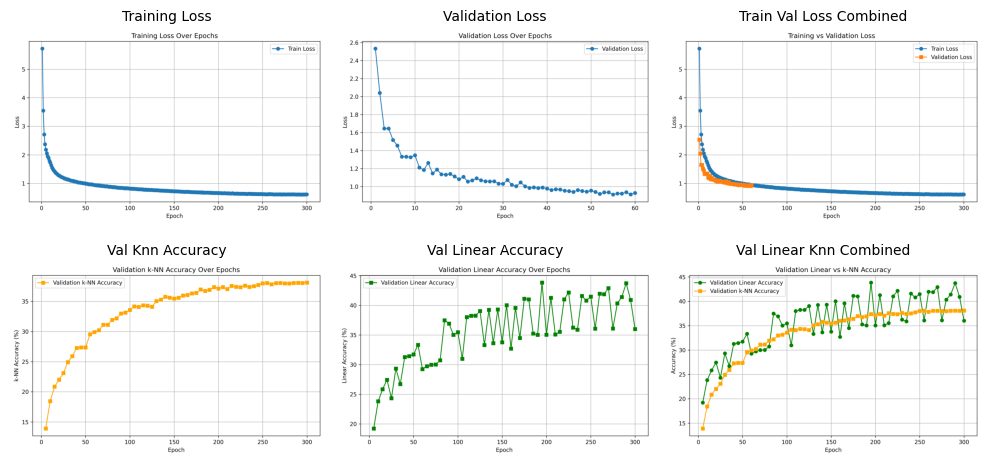

In [11]:
files = [
    "figures/training_loss.png", "figures/validation_loss.png",
    "figures/train_val_loss_combined.png", "figures/val_knn_accuracy.png",
    "figures/val_linear_accuracy.png", "figures/val_linear_knn_combined.png"
]

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for ax, f in zip(axes.ravel(), files):
    ax.imshow(mpimg.imread(f))
    ax.set_title(f.split('/')[-1].replace('.png','').replace('_',' ').title(), fontsize=10)
    ax.axis('off')
plt.tight_layout()

# # 💾 Save the combined figure
# plt.savefig("figures/Figure1.png", dpi=300, bbox_inches="tight")

plt.show()

We can see that both the training and validation losses go down over the epochs, while the k-NN and linear validation accuracies go up. The loss drops quite fast during the first 50 epochs and then decreases more slowly afterward.

In the same way, the k-NN accuracy improves quickly at the start and then increases more gradually. If we had trained for more epochs, the accuracy might have gone up a bit more, but to get a big improvement, we’d probably need more computing power and more data.

Then let's visualise random images in the validation and OOD dataset with their true and predicted labels.   
These were mapped according to a mapping file in order to get both the label as a number but also as a text description.

In [ ]:
os.makedirs("figures", exist_ok=True)

# Random images: true label vs predicted for VALIDATION dataset - Run the visualization and save
visualize_predictions(model, train_loader_plain, val_loader_plain, save_path="figures/val_knn_predictions.png", title="Validation Images — k-NN Predictions vs True Labels")
print("Saved figure as visualize_predictions.png")

# Random images: true label vs predicted for OOD dataset - Run the visualization and save
visualize_predictions(model, ood_train_loader, ood_val_loader, save_path="figures/ood_knn_predictions.png", title="OOD Images — k-NN Predictions vs True Labels")
print("Saved figure as ood_knn_predictions.png")

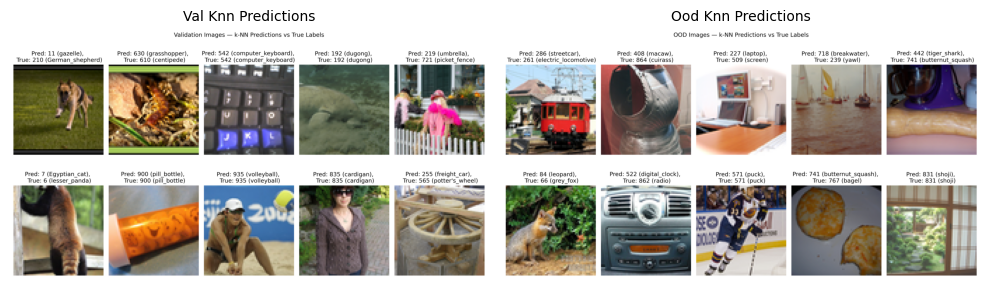

In [4]:
files = [
    "figures/val_knn_predictions.png",
    "figures/ood_knn_predictions.png"
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, f in zip(axes, files):
    ax.imshow(mpimg.imread(f))
    ax.set_title(f.split('/')[-1].replace('.png','').replace('_',' ').title(), fontsize=10)
    ax.axis('off')

plt.tight_layout()
# plt.savefig("figures/Figure2.png", dpi=300, bbox_inches="tight")
plt.show()


In this figure, we show two sets of 10 randomly selected images. The images on the left come from the in-distribution dataset, and those on the right come from the out-of-distribution dataset. Each image is displayed with its true label and the predicted label, shown both as a number and as a text category (using a downloaded label mapping file).

For the in-distribution samples (left), the model correctly predicted 5 out of 10 images. Similarly, for the out-of-distribution samples (right), it got 2 out of 10 correct. However, even when the predictions were wrong, they were often semantically close to the true labels, for instance, an animal image was sometimes classified as another similar animal, a screen was predicted as a laptop, and an electric locomotive was predicted as a streetcar.

Finnaly, a t-SNE visualization was created for the in-distribution and out-of-distribution validation datasets, where each dot represents an image. Twenty random images were highlighted in the plot to examine whether they form clusters.

In [ ]:
# t-SNE on validation embeddings
# Run the visualization and save
visualize_predictions(model, train_loader_plain, val_loader_plain, save_path="figures/val_knn_predictions.png", 
                      title="Validation Images — k-NN Predictions vs True Labels")
print("Saved figure as visualize_predictions.png")

# Run the visualization
visualize_predictions(model, ood_train_loader, ood_val_loader, save_path="figures/ood_knn_predictions.png", 
                      title="OOD Images — k-NN Predictions vs True Labels")
print("Saved figure as ood_knn_predictions.png")

visualize_tsne(model, val_loader_plain, save_path="figures/tsne_embeddings_val.png")
visualize_tsne(model, ood_val_loader, save_path="figures/tsne_embeddings_ood.png")

visualize_tsne_highlight_labels(model, val_loader_plain, save_path="figures/tsne_20_embeddings_val.png", device="cuda", number = 20)
visualize_tsne_highlight_labels(model, ood_val_loader, save_path="figures/tsne_20_embeddings_ood.png", device="cuda", number = 20)

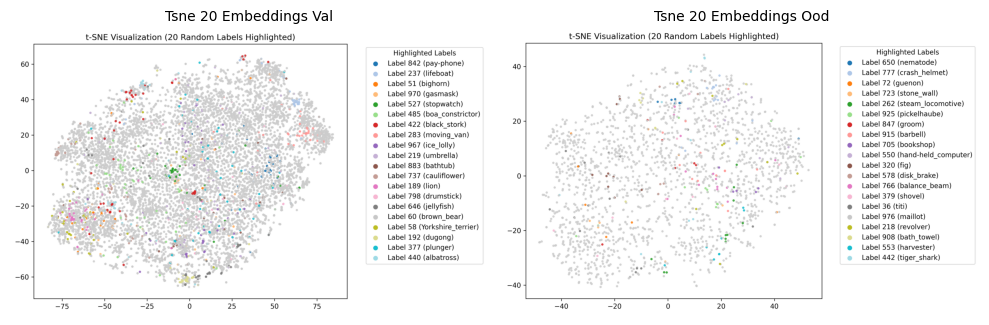

In [ ]:
files = [
    "figures/tsne_20_embeddings_val.png",
    "figures/tsne_20_embeddings_ood.png"
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, f in zip(axes, files):
    ax.imshow(mpimg.imread(f))
    ax.set_title(f.split('/')[-1].replace('.png','').replace('_',' ').title(), fontsize=10)
    ax.axis('off')

plt.tight_layout()
# plt.savefig("figures/Figure3.png", dpi=300, bbox_inches="tight")
plt.show()

In this figure, we show two t-SNE plots: the one on the left represents the validation dataset, and the one on the right corresponds to the out-of-distribution (OOD) dataset. Each dot represents one image. The validation set contains about 1,000 images, while the OOD validation set includes only 200 images.

Since both datasets have 200 labels, we randomly selected 20 of them and colored the t-SNE points based on these labels to see whether samples with the same label cluster together.

From the plots, we can observe that in the validation dataset (left), images with the same label generally form clear clusters — for example, the green cluster in the middle (label 527 – stopwatch) or the salmon-colored cluster on the right (label 283 - moving van). In contrast, in the OOD dataset (right), we notice a similar trend, but the samples with the same label are more spread out and less tightly grouped, likely due to the smaller dataset size.

In [ ]:
print("############################### END ##############################")
end = time.time()                              
elapsed_minutes = (end - start) / 60   
elapsed_hours = (end - start) / 3600           
print(f"TOTAL Time taken: {elapsed_minutes:.2f} minutes")
print(f"TOTAL Time taken: {elapsed_hours:.2f} hours")

 # 7. Submission Instructions

 You must submit the following files:

 - `models.py`: Contains the implementation of your model architecture.

 - `final_model.safetensors`: The trained model weights saved in the safetensors format.

 - `report.md`: A brief report summarizing your approach, design choices, and results.

 - `CS461_Assignment1.ipynb`: The Jupyter notebook containing your code and explanations. Make sure to save your progress before running the cell below.



 You will submit your assignment under a single folder named `/home/cs461_assignment1_submission` containing the above files. \

 Make sure to replace `<SCIPER>`, `<LAST_NAME>`, and `<FIRST_NAME>` with your actual SCIPER number, last name, and first name respectively. \

 The following cell will help you move the files into the submission folder.

In [ ]:
work_dir = Path('.')
output_dir = Path.home() / 'CS461_Assignment/cs461_assignment1_submission'

if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=False)
    
shutil.copy(final_model_path, output_dir / 'final_model.safetensors')
shutil.copy(work_dir / 'models.py', output_dir / 'models.py')
shutil.copy(work_dir / 'CS461_Assignment1.ipynb', output_dir / 'CS461_Assignment1.ipynb')
shutil.copy(work_dir / 'report.md', output_dir / 'report.md')


 Check that all required files are present in the submission folder before running the cell below.

In [ ]:
assert SCIPER is not None and LAST_NAME is not None and FIRST_NAME is not None, "Please set your SCIPER, LAST_NAME, and FIRST_NAME variables."

list_of_files = ['final_model.safetensors', 'models.py', 'CS461_Assignment1.ipynb', 'report.md']
files_found = all((output_dir / f).exists() for f in list_of_files)
assert files_found, f"One or more required files are missing in the submission folder: {list_of_files}"



 You can test whether your submission folder is appropriately structured by using the `eval.py`:

 ```bash

 python eval.py

 ```

In [ ]:
### Uncomment the line below to run the evaluation script and check your model's performance


 ---

 🎉 **Congratulations!**

 You’ve completed Assignment 1. Good luck, and don’t forget to double-check your submission!